In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score
from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.algorithms.preprocessing import Reweighing
from sklearn.impute import SimpleImputer
from ucimlrepo import fetch_ucirepo
from sklearn.decomposition import PCA
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

# Load dataset and Preprocessing

Load the "Communities and Crime" dataset from the UCI repository and do some preprocessing and data analysis 

In [52]:
# Load the dataset
#attrib = read_csv('attributes.csv',sep='\s+')
#data = read_csv('communities.data', names = attrib['attributes'],na_values=["?"])
communities_and_crime = fetch_ucirepo(id=183)
X = communities_and_crime.data.features
y = communities_and_crime.data.targets
y = y.to_numpy().flatten()

X_df = pd.DataFrame(X, columns=communities_and_crime.data.feature_names)

y_df = pd.Series(y, name='ViolentCrimesPerPop')

data = pd.concat([X_df, y_df], axis=1)

In [53]:
print(data.shape)

(1994, 128)


In [54]:
#data = data.drop(columns=["state", "county", "community", "communityname", "fold"], axis=1)
data = data.drop(columns=["fold"], axis=1)
data.head()

,state,county,community,communityname,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,8,?,?,Lakewoodcity,0.19,0.33,0.02,0.90,0.12,0.17,...,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,53,?,?,Tukwilacity,0.00,0.16,0.12,0.74,0.45,0.07,...,0.02,0.12,0.45,?,?,?,?,0.00,?,0.67
2,24,?,?,Aberdeentown,0.00,0.42,0.49,0.56,0.17,0.04,...,0.01,0.21,0.02,?,?,?,?,0.00,?,0.43
3,34,5,81440,Willingborotownship,0.04,0.77,1.00,0.08,0.12,0.10,...,0.02,0.39,0.28,?,?,?,?,0.00,?,0.12
4,42,95,6096,Bethlehemtownship,0.01,0.55,0.02,0.95,0.09,0.05,...,0.04,0.09,0.02,?,?,?,?,0.00,?,0.03


In [55]:
sensitive_attributes = ['racepctblack', 'racePctWhite', 'racePctAsian', 'racePctHisp']

In [56]:
def handle_missing_values(data, sensitive_attributes=None, threshold=50, impute_strategy='mean'):
    data = data.apply(pd.to_numeric, errors='coerce')
    
    missing_values = data.isnull().sum()
    print("Missing Values per Column:\n", missing_values)

    missing_percentage = (missing_values / len(data)) * 100
    
    removed_features = missing_percentage[missing_percentage > threshold].index.tolist()
    data = data.drop(columns=removed_features)
    print("Removed Features due to high missing values:\n", removed_features)
    
    imputer = SimpleImputer(strategy=impute_strategy)
    data_imputed = imputer.fit_transform(data)
    data = pd.DataFrame(data_imputed, columns=data.columns)
    
    return data, removed_features


In [57]:
data, removed_features = handle_missing_values(data, sensitive_attributes)

Missing Values per Column:
 state                     0
county                 1174
community              1177
communityname          1994
population                0
                       ... 
LemasPctPolicOnPatr    1675
LemasGangUnitDeploy    1675
LemasPctOfficDrugUn       0
PolicBudgPerPop        1675
ViolentCrimesPerPop       0
Length: 127, dtype: int64
Removed Features due to high missing values:
 ['county', 'community', 'communityname', 'LemasSwornFT', 'LemasSwFTPerPop', 'LemasSwFTFieldOps', 'LemasSwFTFieldPerPop', 'LemasTotalReq', 'LemasTotReqPerPop', 'PolicReqPerOffic', 'PolicPerPop', 'RacialMatchCommPol', 'PctPolicWhite', 'PctPolicBlack', 'PctPolicHisp', 'PctPolicAsian', 'PctPolicMinor', 'OfficAssgnDrugUnits', 'NumKindsDrugsSeiz', 'PolicAveOTWorked', 'PolicCars', 'PolicOperBudg', 'LemasPctPolicOnPatr', 'LemasGangUnitDeploy', 'PolicBudgPerPop']


# Correlation Analysis

### Finding highly correlated features

In [58]:
correlation_matrix = data.corr()

threshold = 0.8
highly_correlated_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        col1 = correlation_matrix.columns[i]
        col2 = correlation_matrix.columns[j]
        correlation = correlation_matrix.iloc[i, j]
        if abs(correlation) > threshold:
            highly_correlated_pairs.append((col1, col2, correlation))

highly_correlated_pairs.sort(key=lambda x: abs(x[2]), reverse=True)

print("\nHighly correlated feature pairs (correlation > 0.8):")
for pair in highly_correlated_pairs:
    print(f"{pair[0]} and {pair[1]}: {pair[2]:.2f}")


Highly correlated feature pairs (correlation > 0.8):
PctRecImmig8 and PctRecImmig10: 1.00
OwnOccLowQuart and OwnOccMedVal: 0.99
PctRecImmig5 and PctRecImmig8: 0.99
population and numbUrban: 0.99
OwnOccMedVal and OwnOccHiQuart: 0.99
PctRecentImmig and PctRecImmig5: 0.99
RentMedian and MedRent: 0.99
PctRecImmig5 and PctRecImmig10: 0.99
PctFam2Par and PctKids2Par: 0.99
PctLargHouseFam and PctLargHouseOccup: 0.98
FemalePctDiv and TotalPctDiv: 0.98
PctPersOwnOccup and PctHousOwnOcc: 0.98
RentMedian and RentHighQ: 0.98
PctRecentImmig and PctRecImmig8: 0.98
medIncome and medFamInc: 0.98
RentHighQ and MedRent: 0.98
OwnOccLowQuart and OwnOccHiQuart: 0.98
MalePctDivorce and TotalPctDiv: 0.98
perCapInc and whitePerCap: 0.97
PctRecentImmig and PctRecImmig10: 0.97
RentLowQ and RentMedian: 0.96
PctRecImmig10 and PctForeignBorn: 0.96
PctBSorMore and PctOccupMgmtProf: 0.95
RentLowQ and MedRent: 0.95
population and NumUnderPov: 0.95
PctRecImmig8 and PctForeignBorn: 0.95
PctLess9thGrade and PctNotHSGra

### Finding features highly correlated with 'ViolentCrimesPerPop'


Features highly correlated with ViolentCrimesPerPop (|correlation| > 0.5):
PctIlleg: 0.74
racepctblack: 0.63
pctWPubAsst: 0.57
FemalePctDiv: 0.56
TotalPctDiv: 0.55
MalePctDivorce: 0.53
PctPopUnderPov: 0.52
PctUnemployed: 0.50
PctPersOwnOccup: -0.53
pctWInvInc: -0.58
PctTeen2Par: -0.66
PctYoungKids2Par: -0.67
racePctWhite: -0.68
PctFam2Par: -0.71
PctKids2Par: -0.74


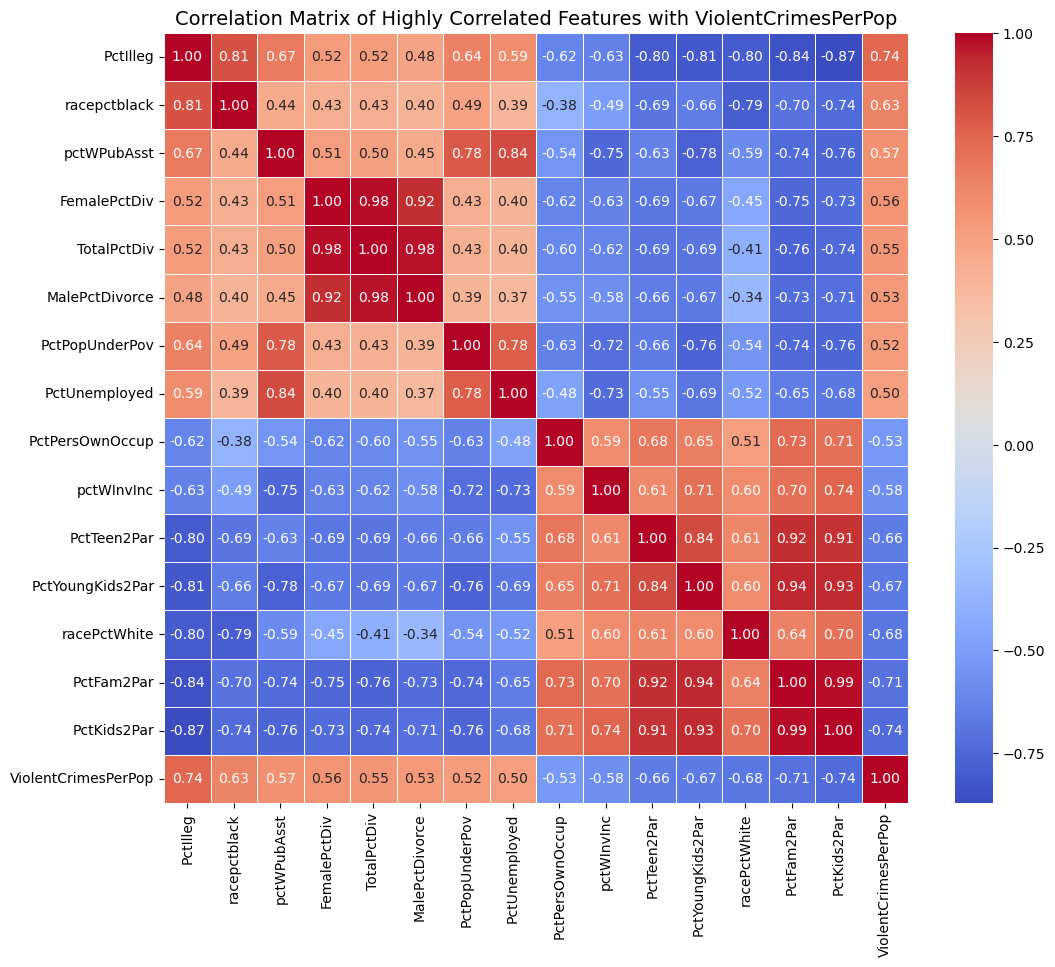

In [59]:
correlation_matrix = data.corr()
threshold = 0.5

correlations_with_violentcrime = correlation_matrix['ViolentCrimesPerPop'].drop('ViolentCrimesPerPop')
highly_correlated_features = correlations_with_violentcrime[correlations_with_violentcrime.abs() > threshold].sort_values(ascending=False)

print("\nFeatures highly correlated with ViolentCrimesPerPop (|correlation| > 0.5):")
for feature, correlation in highly_correlated_features.items():
    print(f"{feature}: {correlation:.2f}")

if not highly_correlated_features.empty:
  highly_correlated_features = highly_correlated_features.index.tolist()
  highly_correlated_features.append('ViolentCrimesPerPop')
  subset_data = data[highly_correlated_features]
  correlation_matrix_subset = subset_data.corr()

  plt.figure(figsize=(12, 10))
  sns.heatmap(correlation_matrix_subset, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
  plt.title('Correlation Matrix of Highly Correlated Features with ViolentCrimesPerPop', fontsize=14)
  plt.show()
else:
  print("\nNo features found with correlation greater than the threshold.")

# Analysing Racial Features

There are 4 columns for races. These are analysed to understand any racial bias in the dataset

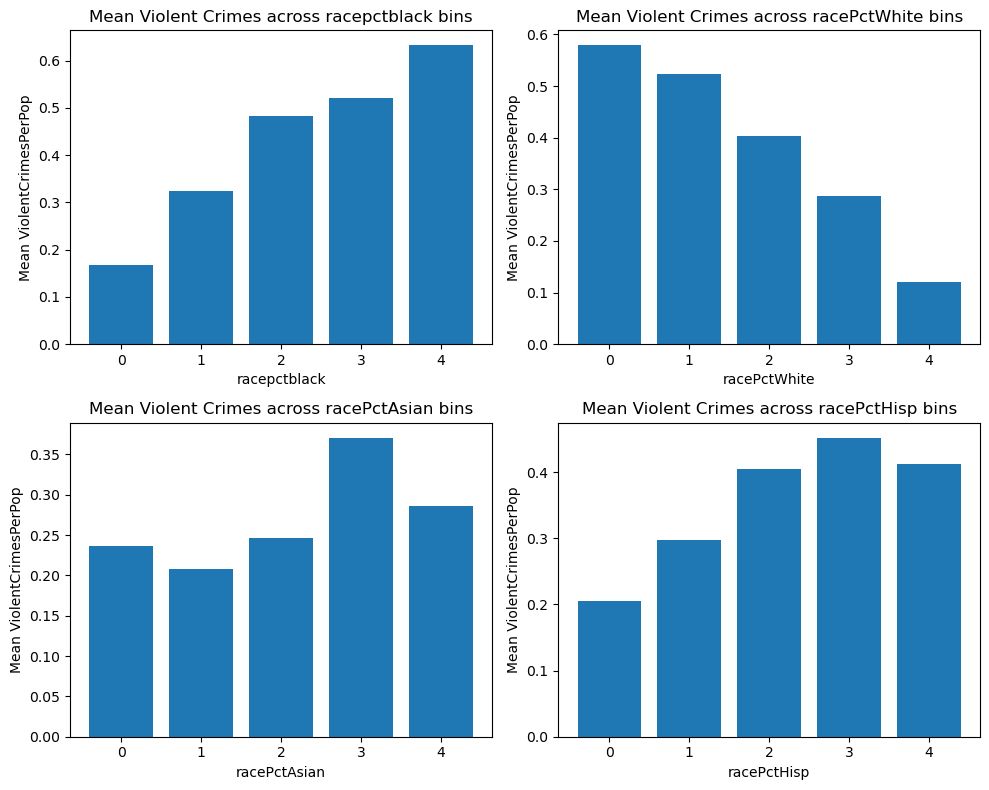

In [60]:
plt.figure(figsize=(10, 8))

for i, col in enumerate(sensitive_attributes):
    plt.subplot(2, 2, i + 1)
    data[col] = pd.cut(data[col], bins=np.linspace(0, 1, 6), labels=False)
    mean_crime = data.groupby(col)['ViolentCrimesPerPop'].mean()
    
    plt.bar(mean_crime.index, mean_crime.values)
    plt.title(f'Mean Violent Crimes across {col} bins')
    plt.xlabel(col)
    plt.ylabel('Mean ViolentCrimesPerPop')

plt.tight_layout()
plt.show()

From the bar charts, we can notice that for different races, the distribution of violent crimes varies. For 'racePCTWhite', the number of violent crimes are shown low. The concentration of crimes are mainly in the lowest bar. While for 'racepctblack', it is very high in the last bar indicating that they commit very violent crimes. For 'racePctasian' and 'racePctHisp', it is highest in the 4th bars. However, there are more crimes in all the bars for 'racepctBlack', 'racePctAsian', and 'racePcthisp' compared to 'racePctwhite'. 

This difference could be because the population of white people are more compared to the other races. Let's analyse that and find out. 

To do this, the races are grouped by the 'state' and the mean value is taken to plot the graphs.

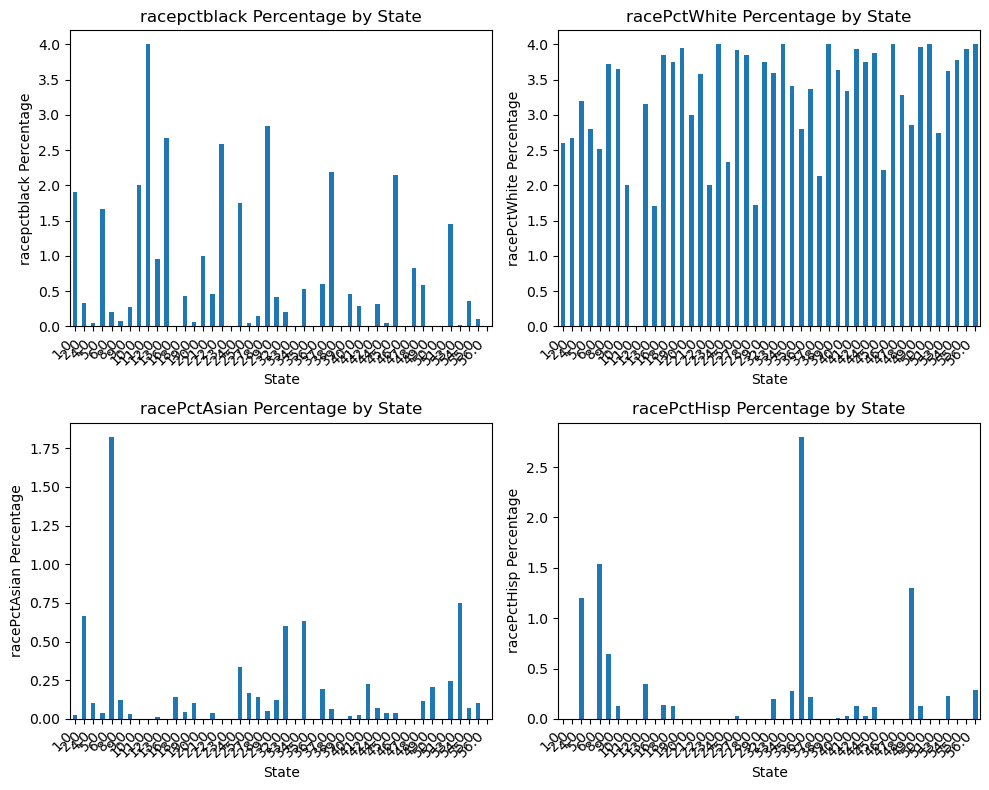

In [61]:
plt.figure(figsize=(10, 8))
for i, col in enumerate(sensitive_attributes):
    plt.subplot(2, 2, i + 1) 
    
    grouped_data = data.groupby('state')[col].mean()
    grouped_data.plot(kind='bar')
    
    plt.title(f'{col} Percentage by State')
    plt.xlabel('State')
    plt.ylabel(f'{col} Percentage')
    plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

Clearly, The percentage of white population is higher than the others in most states. From this, we can infer that the data has sample size issues and selection biases.

There isn't enough data to represent different racial communities.

We can also notice that there are geographical bias too in this. Due to the lower population of 'racepctblack','racePctAsian', 'racePctHisp'in most cities, the crime committed by them are highlighted in the model.

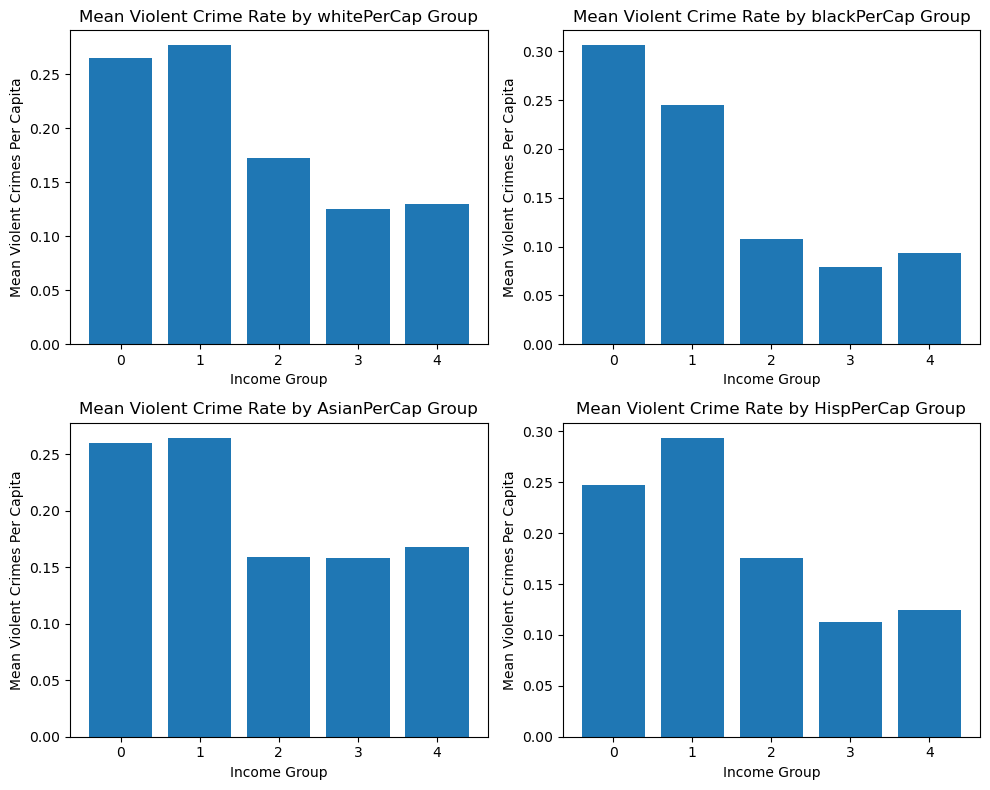

In [62]:
income_cols = ['whitePerCap', 'blackPerCap', 'AsianPerCap', 'HispPerCap']

plt.figure(figsize=(10, 8)) 
for i, col in enumerate(income_cols):
    plt.subplot(2,2, i+1)
    num_bins = 5 
    data[f'{col}_group'] = pd.cut(data[col], bins=np.linspace(data[col].min(), data[col].max(), num_bins + 1), labels=False, include_lowest=True)
    mean_crime_by_income = data.groupby(f'{col}_group')['ViolentCrimesPerPop'].mean()
    
    plt.bar(mean_crime_by_income.index, mean_crime_by_income.values)
    plt.xlabel('Income Group')
    plt.ylabel('Mean Violent Crimes Per Capita')
    plt.title(f'Mean Violent Crime Rate by {col} Group')
    plt.xticks(mean_crime_by_income.index)

plt.tight_layout()
plt.show()

As Income increases, the crime rate decreases which shows poverty or lack of employment is a factor for rise in crime rates.

Considering the history of Black people in US, the initial slavery and racial bias in the society is also a reason for the higher crime rate among the african americans. Even though the slavery ended way back, the societal bias still exists to some extend. This results in the lack of opportunities and poverty in their communities leading to the higher crime rates.

The dataset supports this hypothesis. It aligns with what's expected and confirms a preexisting belief. Thus we can say that the dataset also has optimist bias.

# Analysing Age Features

<Figure size 800x500 with 0 Axes>

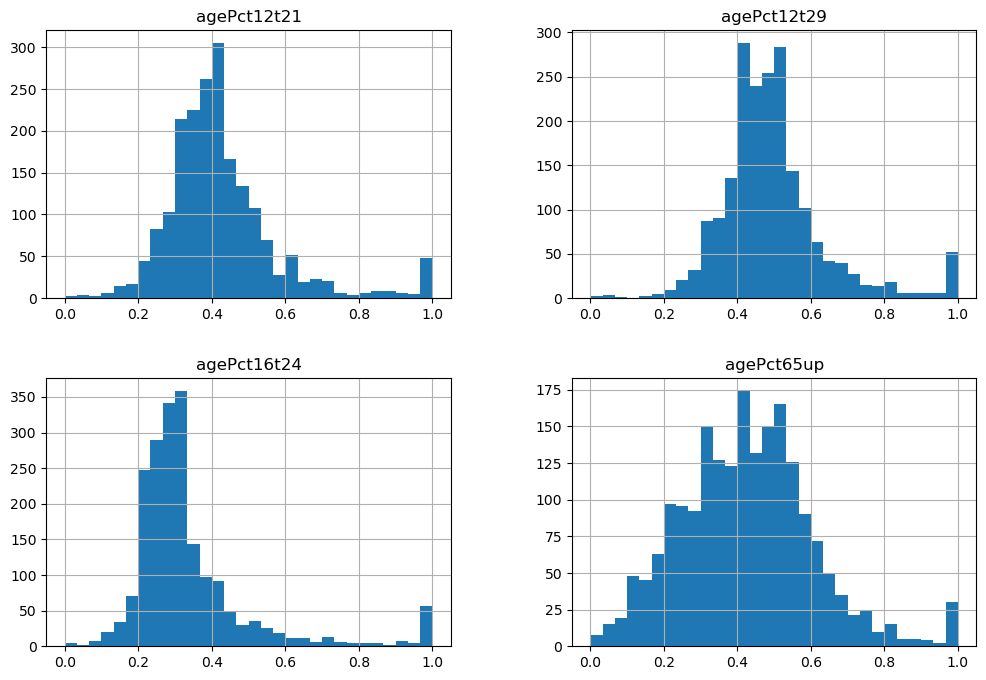

In [63]:
age_columns = ['agePct12t21', 'agePct12t29', 'agePct16t24', 'agePct65up']
plt.figure(figsize=(8, 5))
data[age_columns].hist(bins=30, figsize=(12, 8))
plt.show()

Analysing the distribution of young and old people in different states

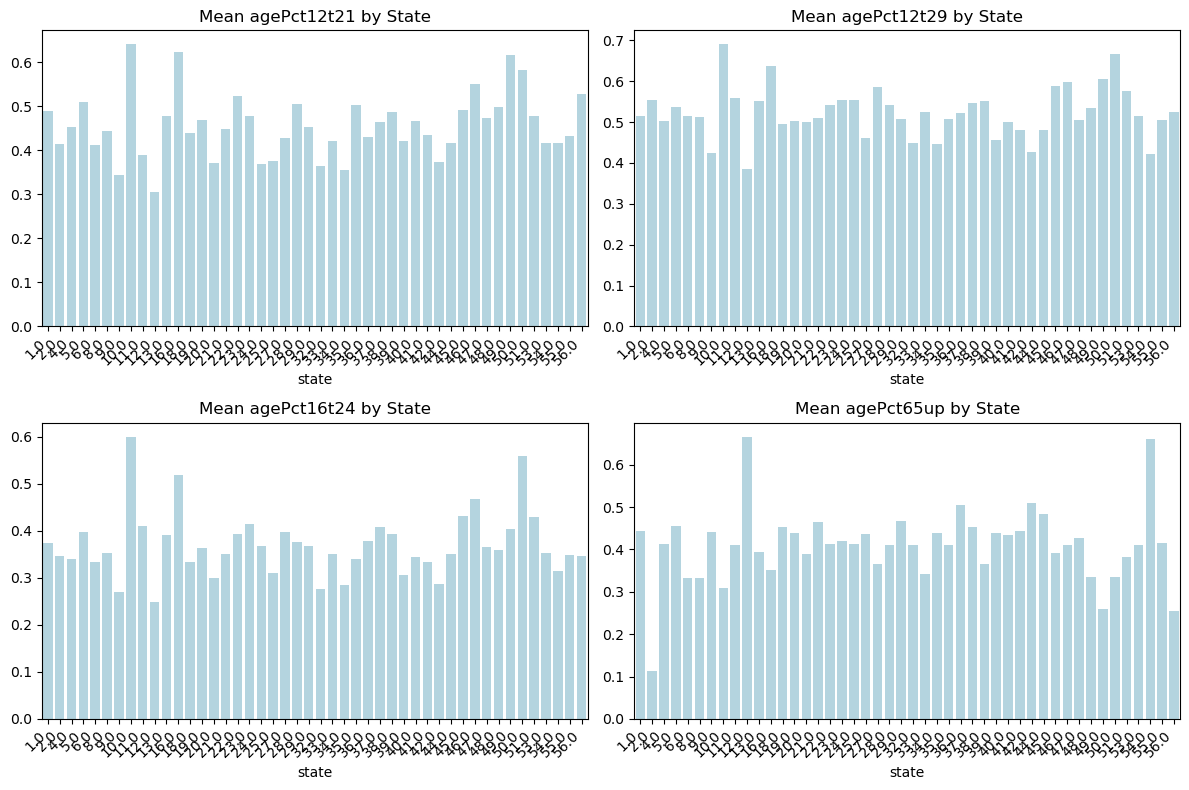

In [64]:
plt.figure(figsize=(12, 8))
for i, col in enumerate(age_columns):
    plt.subplot(2, 2, i + 1)
    state_means = data.groupby('state')[col].mean()
    sns.barplot(x=state_means.index, y=state_means.values,color='lightblue')
    plt.title(f'Mean {col} by State')
    plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

There is a higher population of younger people compared to older people. Especially in the age12to29, you can see an increase which means there are more people in the mid 20s. However, in some states, it is the opposite. The population of older people are a bit spread across the graph. This shows the data isn't evenly distributed for all the age categories. This can result in sample issues.

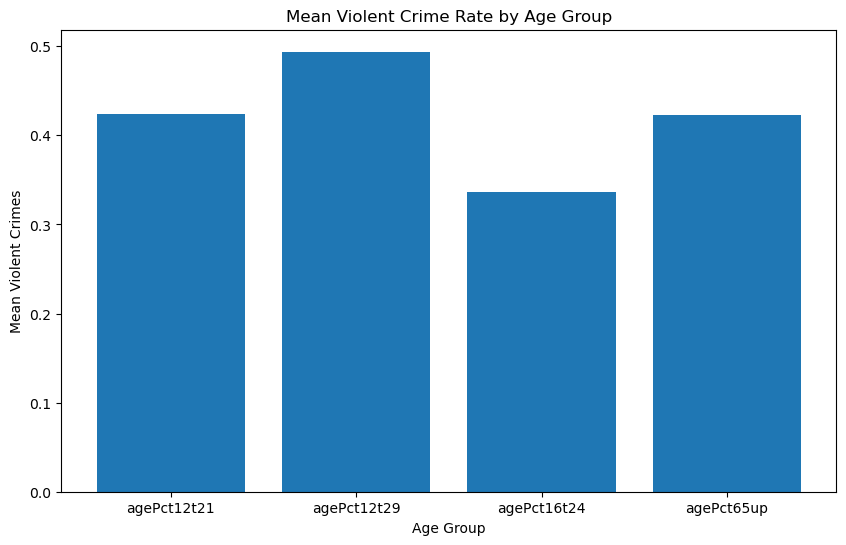

In [65]:
mean_crime_by_age = data[age_columns].mean()

plt.figure(figsize=(10, 6))
plt.bar(age_columns, mean_crime_by_age.values)
plt.xlabel('Age Group')
plt.ylabel('Mean Violent Crimes')
plt.title('Mean Violent Crime Rate by Age Group')
plt.show()

Here, the age groups for young people are overlapping and causing confusions. So, we cannot really infer a clear conclusion from this. Let's analyse further by grouping young and old ones separately.

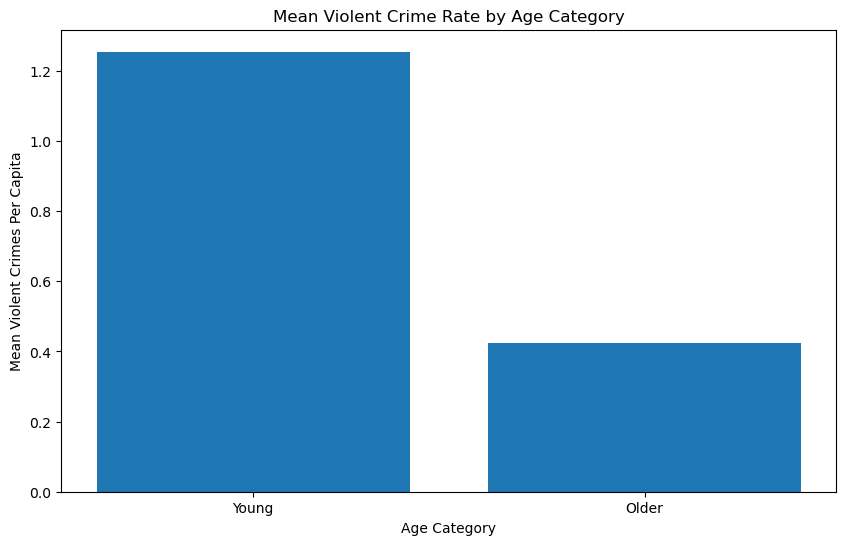

In [66]:
age_categories = {
    'Young': ['agePct12t21', 'agePct12t29', 'agePct16t24'],
    'Older': ['agePct65up']
}

data['Young'] = data[age_categories['Young']].sum(axis=1)
data['Older'] = data[age_categories['Older']].sum(axis=1)
mean_crime_by_age_category = data[['Young', 'Older']].mean()

plt.figure(figsize=(10, 6))
plt.bar(mean_crime_by_age_category.index, mean_crime_by_age_category.values)
plt.xlabel('Age Category')
plt.ylabel('Mean Violent Crimes Per Capita')
plt.title('Mean Violent Crime Rate by Age Category')
plt.show()

Even though there is some overlapping, the bar for young people are really high. Therefore, we can say that they commit more crimes that old people. This is possibly due to unemployment and other factors like family and kids. let's look at the employment of young people to understand the reasons behind this.

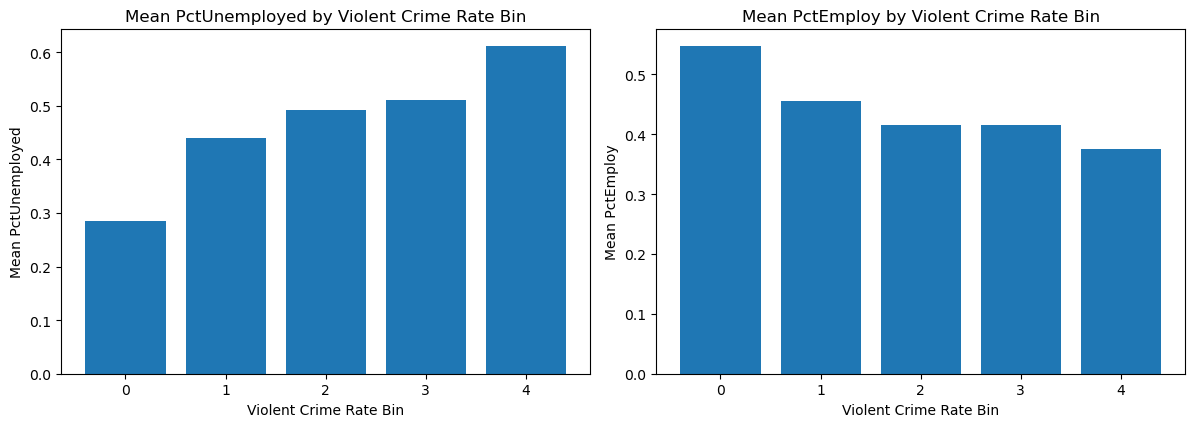

In [67]:
edu_emp_cols = ['PctUnemployed', 'PctEmploy']


num_bins = 5
data['crime_bins'] = pd.cut(data['ViolentCrimesPerPop'], bins=np.linspace(data['ViolentCrimesPerPop'].min(), data['ViolentCrimesPerPop'].max(), num_bins + 1), labels=False)

plt.figure(figsize=(18, 12))

for i, col in enumerate(edu_emp_cols):
    plt.subplot(3, 3, i + 1)
    mean_edu_emp_by_crime = data.groupby('crime_bins')[col].mean()
    plt.bar(mean_edu_emp_by_crime.index, mean_edu_emp_by_crime.values)
    plt.xlabel('Violent Crime Rate Bin')
    plt.ylabel(f'Mean {col}')
    plt.title(f'Mean {col} by Violent Crime Rate Bin')

plt.tight_layout()
plt.show()

## Analysing The Effect Of Family Structure On Crime Rate

In the correlation analysis, there is a strong correlation between 'MalePctDivorce', 'FemalePctDiv', 'TotalPctDiv' with 'ViolentCrimesPerPop. Let's analyse to make sure it's right. Also, this could be another factor that increases crime rates in young people.

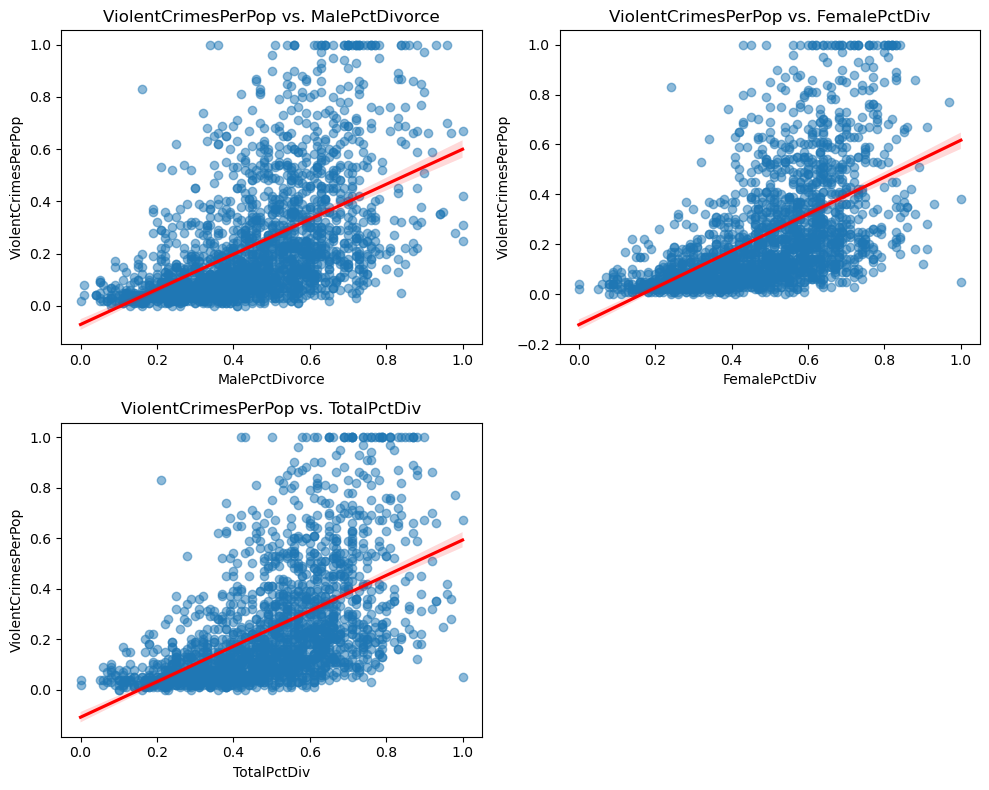

In [68]:
divorce_cols = ['MalePctDivorce', 'FemalePctDiv', 'TotalPctDiv']

plt.figure(figsize=(10, 8)) 

for i, col in enumerate(divorce_cols):
    plt.subplot(2, 2, i + 1)
    sns.regplot(x=col, y='ViolentCrimesPerPop', data=data, scatter_kws={'alpha':0.5}, line_kws={'color':'red'}) #Seaborn regplot
    plt.title(f'ViolentCrimesPerPop vs. {col}')
    plt.xlabel(col)
    plt.ylabel('ViolentCrimesPerPop')

plt.tight_layout()
plt.show()

All three plots show a positive correlation. As the percentage of divorced males, females, or the total population increases, the violent crime rate per capita also tends to increase.

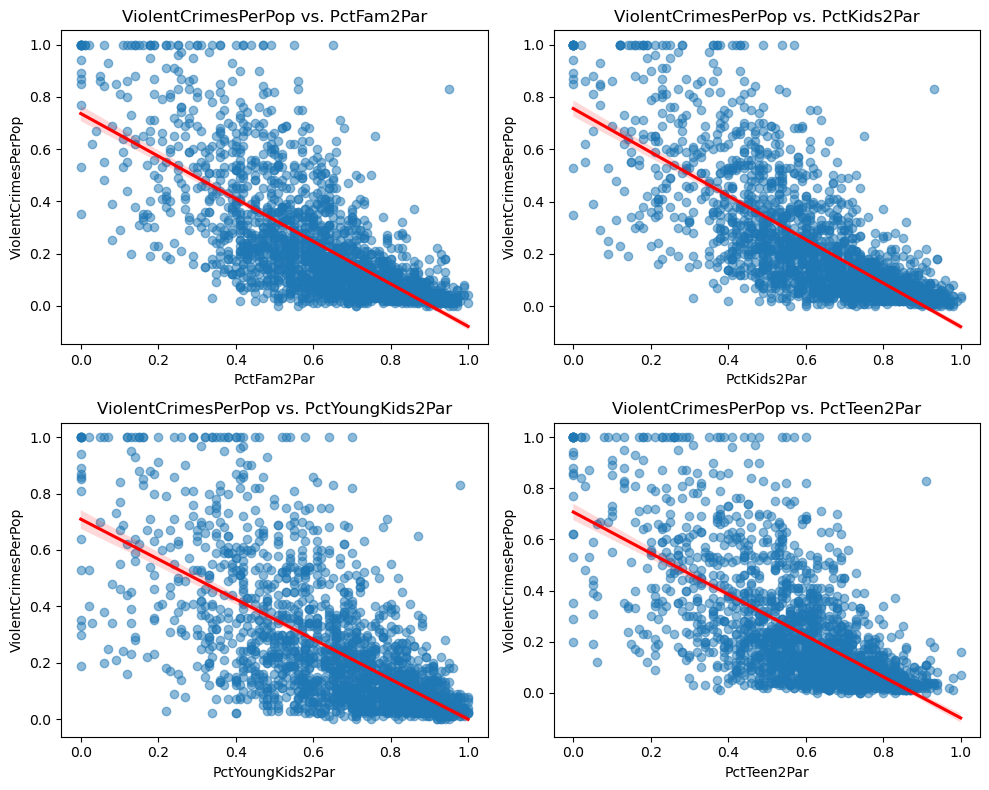

In [69]:
family_struct_cols = ['PctFam2Par', 'PctKids2Par', 'PctYoungKids2Par', 'PctTeen2Par']

plt.figure(figsize=(10, 8))

for i, col in enumerate(family_struct_cols):
    plt.subplot(2, 2, i + 1)
    sns.regplot(x=col, y='ViolentCrimesPerPop', data=data, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
    plt.title(f'ViolentCrimesPerPop vs. {col}')
    plt.xlabel(col)
    plt.ylabel('ViolentCrimesPerPop')

plt.tight_layout()
plt.show()

The plots are showing a very high negative correlation which means parents (both parents present) who have young and teens kids, the crime rate is low.
Both positive and negative correlations are important and should be considered when analyzing the relationship between variables. Understanding factors that increase or decrease crime are important.

# Biases Identified In The Dataset
* Selection bias: The dataset is not representative of the population.
* Sample size issues: Some population samples are too small to draw reliable conclusions.
* Geographical bias: It tends to show high crime rates in areas where there are more people from black, hispanic or asian origin.
* Optimist bias: The data includes positive examples of a hypothesis reaffirming an existing belief.

In [70]:
data = data.drop(columns=["state"], axis=1)

In [71]:
data.head()

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,PctUsePubTrans,LemasPctOfficDrugUn,ViolentCrimesPerPop,whitePerCap_group,blackPerCap_group,AsianPerCap_group,HispPerCap_group,Young,Older,crime_bins
0,0.19,0.33,0.0,4.0,0.0,0.0,0.34,0.47,0.29,0.32,...,0.20,0.32,0.20,1,1,1,2,1.10,0.32,0.0
1,0.00,0.16,0.0,3.0,2.0,0.0,0.26,0.59,0.35,0.27,...,0.45,0.00,0.67,1,1,1,1,1.20,0.27,3.0
2,0.00,0.42,2.0,2.0,0.0,0.0,0.39,0.47,0.28,0.32,...,0.02,0.00,0.43,1,1,1,1,1.14,0.32,2.0
3,0.04,0.77,4.0,0.0,0.0,0.0,0.51,0.50,0.34,0.21,...,0.28,0.00,0.12,1,1,1,2,1.35,0.21,0.0
4,0.01,0.55,0.0,4.0,0.0,0.0,0.38,0.38,0.23,0.36,...,0.02,0.00,0.03,2,1,3,2,0.99,0.36,0.0


In [72]:
data, removed_features = handle_missing_values(data, sensitive_attributes)

Missing Values per Column:
 population             0
householdsize          0
racepctblack         134
racePctWhite          33
racePctAsian           8
                    ... 
AsianPerCap_group      0
HispPerCap_group       0
Young                  0
Older                  0
crime_bins            10
Length: 108, dtype: int64
Removed Features due to high missing values:
 []


In [73]:
sensitive_data = data[sensitive_attributes].copy()

# Modeling

XGBoost model is used for modeling along with RandomizedSearchCV to hypertune the model. After that we are calculating R2 and RMSE metric.
Before modeling we will scale the features and do PCA with components 10. Here PCA will reduce the dimensionality of the dataset X_scaled to 10 components.

In [74]:
X = data.drop("ViolentCrimesPerPop", axis=1)
y = data["ViolentCrimesPerPop"]
#Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [75]:
#PCA with 10 components
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_scaled)
print(pca.explained_variance_ratio_)

[0.25326765 0.15946658 0.08969119 0.07988609 0.05436818 0.04115968
 0.03166193 0.02863568 0.02048345 0.01570802]


In [76]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)
X_sensitive_train, X_sensitive_test, y_sensitive_train, y_sensitive_test = train_test_split(sensitive_data, y, test_size=0.2, random_state=42)

In [77]:
def train_xgboost_with_random_search(X_train, y_train, X_test, y_test):
    param_grid = {
        'max_depth': [3, 4, 5],
        'learning_rate': [0.01, 0.05, 0.1],
        'n_estimators': [50, 100],
        'subsample': [0.7, 0.8],
        'colsample_bytree': [0.7, 1.0]
    }

    xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
    random_search = RandomizedSearchCV(
        estimator=xgb_model,
        param_distributions=param_grid,
        n_iter=72,
        scoring='neg_mean_squared_error',
        cv=5,
        verbose=2,
        n_jobs=-1,
        random_state=42
    )
    random_search.fit(X_train, y_train)

    print(f"Best parameters : {random_search.best_params_}")
    best_model = random_search.best_estimator_

    y_pred_test = best_model.predict(X_test)
    y_pred_train = best_model.predict(X_train)
    print("")
    print(f"Performance of XGBoost - RandomSearch")
    print("")

    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    r2_test = r2_score(y_test, y_pred_test)
    print("On test set:")
    print(f"RMSE: {rmse_test:.4f}")
    print(f"R²: {r2_test:.4f}")
    print("")
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    r2_train = r2_score(y_train, y_pred_train)
    print("On train set:")
    print(f"RMSE: {rmse_train:.4f}")
    print(f"R²: {r2_train:.4f}")

    return best_model

In [78]:
model_xgb = train_xgboost_with_random_search(X_train, y_train, X_test, y_test)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best parameters : {'subsample': 0.7, 'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.1, 'colsample_bytree': 1.0}

Performance of XGBoost - RandomSearch

On test set:
RMSE: 0.1277
R²: 0.6598

On train set:
RMSE: 0.0859
R²: 0.8672


In [79]:
model_xgb_sensitive = train_xgboost_with_random_search(X_sensitive_train, y_sensitive_train,X_sensitive_test, y_sensitive_test)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best parameters : {'subsample': 0.7, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.7}

Performance of XGBoost - RandomSearch

On test set:
RMSE: 0.1511
R²: 0.5235

On train set:
RMSE: 0.1632
R²: 0.5211


# Calculate Fairness

Now we will calculate fairness metrics such as Disparate Impact, Mean Difference, and Statistical Parity Difference for each sensitive attribute in the dataset.We will also visualize the fairness metrics across sensitive attributes.

In [80]:
#sensitive_attributes = ['racepctblack', 'racePctWhite', 'racePctAsian', 'racePctHisp']

In [81]:
def prepare_fairness_dataset(y_test, y_pred, X_sensitive_test):    
    y_pred_df = pd.DataFrame(y_pred, columns=['predictions']).reset_index(drop=True)
    y_test_df = pd.DataFrame(y_test, columns=['ViolentCrimesPerPop']).reset_index(drop=True)
    X_sensitive_test = X_sensitive_test.reset_index(drop=True)

    combined_df = pd.concat([y_test_df, y_pred_df, pd.DataFrame(X_sensitive_test)], axis=1)
    combined_df = combined_df.dropna()

    return combined_df

In [82]:
def get_privileged_unprivileged_groups(combined_df, sensitive_attributes):    
    def is_privileged(value):
        return 1 if value < 0.30 else 0

    datasets = {}
    privileged_groups = {}
    unprivileged_groups = {}
    
    for sensitive_attribute in sensitive_attributes:
        combined_df[sensitive_attribute] = combined_df[sensitive_attribute].apply(is_privileged)

        dataset = StandardDataset(
            combined_df,
            label_name='ViolentCrimesPerPop', 
            favorable_classes=[1],
            protected_attribute_names=[sensitive_attribute], 
            privileged_classes=[lambda x: is_privileged(x) == 1],
        )

        datasets[sensitive_attribute] = dataset
        privileged_groups[sensitive_attribute] = [{sensitive_attribute: 1}]
        unprivileged_groups[sensitive_attribute] = [{sensitive_attribute: 0}]

    return datasets, privileged_groups, unprivileged_groups

In [83]:
def evaluate_fairness(datasets, privileged_groups, unprivileged_groups, sensitive_attributes):
    disparate_impact_values = []
    mean_diff_values = []
    stat_parity_diff_values = []

    for sensitive_attribute in sensitive_attributes:
        dataset = datasets[sensitive_attribute]
        metric = BinaryLabelDatasetMetric(
            dataset,
            privileged_groups=privileged_groups[sensitive_attribute],
            unprivileged_groups=unprivileged_groups[sensitive_attribute]
        )

        num_privileged_fav = metric.num_positives(privileged=True)

        if num_privileged_fav == 0:
            disparate_impact = None
            print(f"No favorable outcomes for privileged group in {sensitive_attribute}.")
        else:
            disparate_impact = metric.disparate_impact()

        mean_difference = metric.mean_difference()
        stat_parity_difference = metric.statistical_parity_difference()

        disparate_impact_values.append(disparate_impact)
        mean_diff_values.append(mean_difference)
        stat_parity_diff_values.append(stat_parity_difference)

        print(f"Fairness Metric for sensitive attribute {sensitive_attribute}:")
        print(f"  Disparate Impact: {disparate_impact}")
        print(f"  Mean Difference: {mean_difference}")
        print(f"  Statistical Parity Difference: {stat_parity_difference}")

    return disparate_impact_values, mean_diff_values, stat_parity_diff_values


In [84]:
def visualize_graph(sensitive_attributes, disparate_impact_values, mean_diff_values, stat_parity_diff_values):
    disparate_impact_values = [val if val is not None else 0 for val in disparate_impact_values]
    colors = ['red', 'blue', 'green', 'orange']

    # Disparate Impact Plot
    plt.figure(figsize=(8, 6))
    plt.bar(sensitive_attributes, disparate_impact_values, color=colors)
    plt.title('Disparate Impact vs Sensitive Attributes')
    plt.xlabel('Sensitive Attribute')
    plt.ylabel('Disparate Impact')
    plt.ylim(0, 30)
    plt.show()

    # Mean Difference Plot
    plt.figure(figsize=(8, 6))
    plt.bar(sensitive_attributes, mean_diff_values, color=colors)
    plt.title('Mean Difference for Sensitive Attributes')
    plt.xlabel('Sensitive Attribute')
    plt.ylabel('Mean Difference')
    plt.ylim(-0.1, 0.2)
    plt.show()

    # Statistical Parity Difference Plot
    plt.figure(figsize=(8, 6))
    plt.bar(sensitive_attributes, stat_parity_diff_values, color=colors)
    plt.title('Statistical Parity Difference for Sensitive Attributes')
    plt.xlabel('Sensitive Attribute')
    plt.ylabel('Statistical Parity Difference')
    plt.ylim(-0.1, 0.2)
    plt.show()

In [85]:
y_pred = model_xgb.predict(X_test)
print("Evaluation of the performance of the model:")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}")
print(f"R²: {r2_score(y_test, y_pred)}")

Evaluation of the performance of the model:
RMSE: 0.12765106020529032
R²: 0.659786218381458


In [86]:
print(X_sensitive_test[['racepctblack', 'racePctWhite', 'racePctAsian', 'racePctHisp']].describe())
print(X_sensitive_test[['racepctblack', 'racePctWhite', 'racePctAsian', 'racePctHisp']].isnull().sum())

       racepctblack  racePctWhite  racePctAsian  racePctHisp
count    399.000000    399.000000    399.000000   399.000000
mean       0.532697      3.317425      0.423559     0.417720
std        1.021371      1.018901      0.936982     0.956138
min        0.000000      0.000000      0.000000     0.000000
25%        0.000000      3.000000      0.000000     0.000000
50%        0.000000      4.000000      0.000000     0.000000
75%        0.604301      4.000000      0.000000     0.000000
max        4.000000      4.000000      4.000000     4.000000
racepctblack    0
racePctWhite    0
racePctAsian    0
racePctHisp     0
dtype: int64


Fairness Metric for sensitive attribute racepctblack:
  Disparate Impact: 0.07872078720787208
  Mean Difference: -0.043184963099631
  Statistical Parity Difference: -0.043184963099631
Fairness Metric for sensitive attribute racePctWhite:
  Disparate Impact: 22.4
  Mean Difference: 0.2729591836734694
  Statistical Parity Difference: 0.2729591836734694
No favorable outcomes for privileged group in racePctAsian.
Fairness Metric for sensitive attribute racePctAsian:
  Disparate Impact: None
  Mean Difference: 0.02287581699346405
  Statistical Parity Difference: 0.02287581699346405
Fairness Metric for sensitive attribute racePctHisp:
  Disparate Impact: 0.12327868852459016
  Mean Difference: -0.0466341123125218
  Statistical Parity Difference: -0.0466341123125218


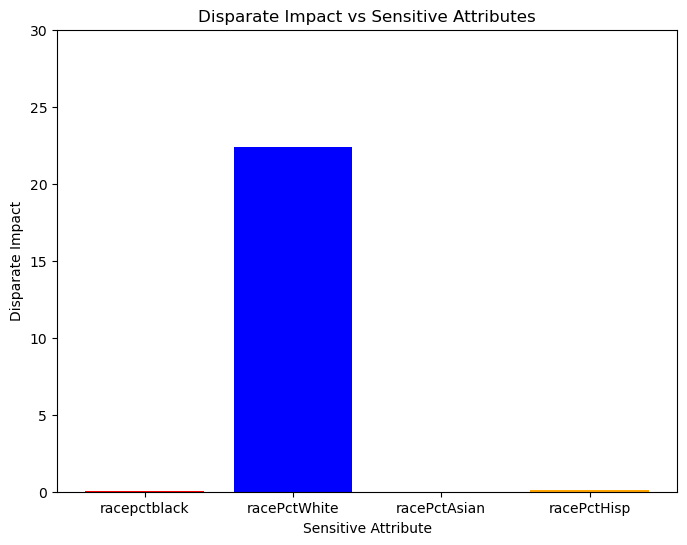

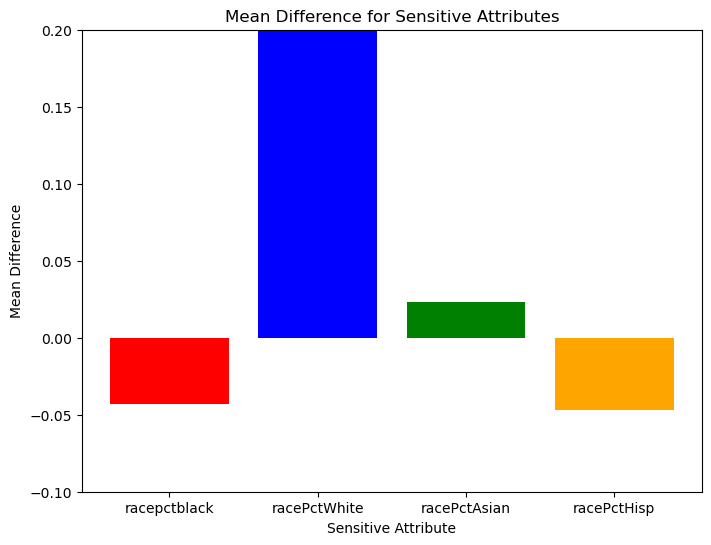

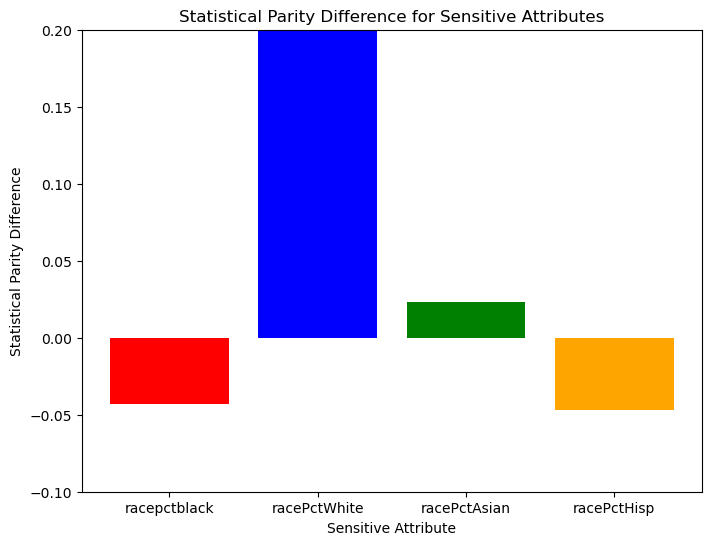

In [87]:
combined_dataset = prepare_fairness_dataset(y_test, y_pred, X_sensitive_test)
datasets, privileged_groups, unprivileged_groups = get_privileged_unprivileged_groups(combined_dataset, sensitive_attributes)
disparate_impact_values, mean_diff_values, stat_parity_diff_values = evaluate_fairness(datasets, privileged_groups, unprivileged_groups, sensitive_attributes)
visualize_graph(sensitive_attributes,disparate_impact_values,mean_diff_values,stat_parity_diff_values)

*Disparate Impact*: This value indicates a significant disparity between the two groups - privileged and unprivileged.Disparate Impact should be close to 1. A value below 0.8 or above 1.25 indicates bias in the model. In our case, for racepctblack value is much lesser than 0.8 while racepctwhite value is greater than 1.25. So bias exists.

*Statistical Parity Difference*: It measures the difference in the proportion of favorable outcomes between the privileged and unprivileged groups. A value close to 0 is ideal, suggesting the model is providing equal treatment to both groups. Here, the values are not closer to zero.

*Mean Difference*:The Mean Difference represents the average difference in predicted outcomes between the two groups. A value close to 0 indicates that there is no significant difference in predictions between the privileged and unprivileged groups. Here, the values are not closer to zero.

# Bias Mitigation using Reweighing and then remodeling

Now we will create a fair dataset through reweighing, then training with this fairer dataset, and then evaluating the model’s fairness post-reweighing. We also calculate metrics like Disparate Impact, Mean Difference, and Statistical Parity Difference, to ensure that the model is making unbiased decisions.

c:\Users\USER\anaconda3\envs\ML_course\Lib\site-packages\aif360\algorithms\preprocessing\reweighing.py:66: RuntimeWarning: divide by zero encountered in scalar divide
  self.w_p_fav = n_fav*n_p / (n*n_p_fav)


Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best parameters : {'subsample': 0.7, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.05, 'colsample_bytree': 1.0}

Performance of XGBoost - RandomSearch

On test set:
RMSE: 0.0692
R²: 0.7394

On train set:
RMSE: 0.0614
R²: 0.7774
After Reweighing:racepctblack
  Disparate Impact: 0.9999999999999998
  Mean Difference: -3.469446951953614e-18
  Statistical Parity Difference: -3.469446951953614e-18
After Reweighing:racePctWhite
  Disparate Impact: 1.0000000000000002
  Mean Difference: 3.469446951953614e-18
  Statistical Parity Difference: 3.469446951953614e-18
After Reweighing:racePctAsian
  Disparate Impact: inf
  Mean Difference: 0.0175438596491228
  Statistical Parity Difference: 0.0175438596491228
After Reweighing:racePctHisp
  Disparate Impact: 1.0000000000000002
  Mean Difference: 3.469446951953614e-18
  Statistical Parity Difference: 3.469446951953614e-18


c:\Users\USER\anaconda3\envs\ML_course\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: divide by zero encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)


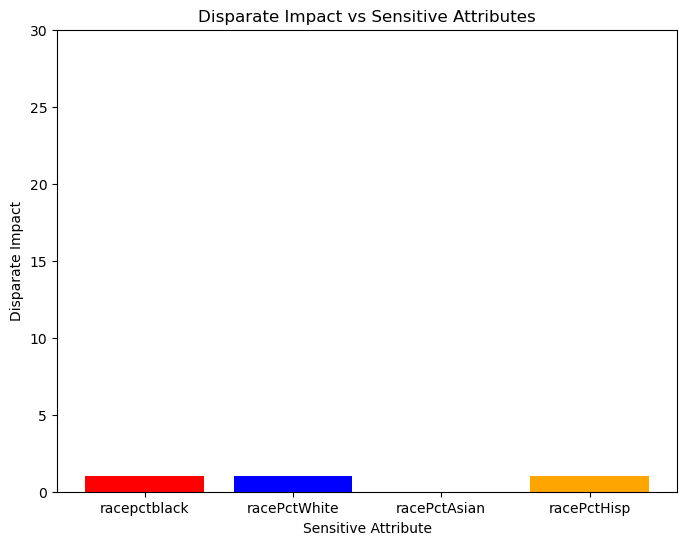

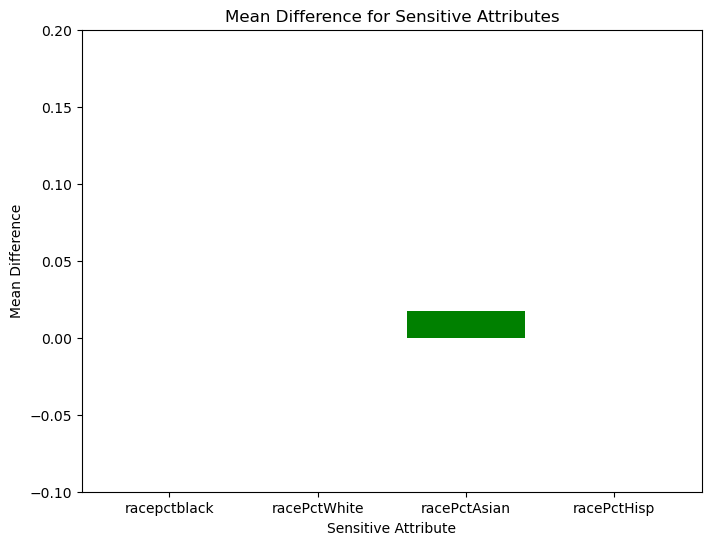

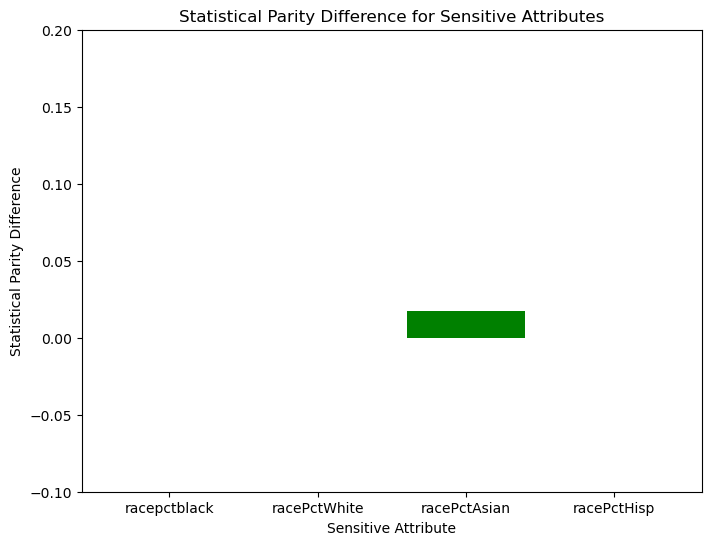

In [89]:
datasets_reweighed = {}
for attr in sensitive_attributes:
    dataset = datasets[attr]
    reweighing = Reweighing(
        privileged_groups=privileged_groups[attr],
        unprivileged_groups=unprivileged_groups[attr]
    )
    
    datasets_reweighed[attr] = reweighing.fit_transform(dataset)

X_reweighed = np.vstack([datasets_reweighed[attr].features for attr in sensitive_attributes])
y_reweighed = np.hstack([datasets_reweighed[attr].labels.ravel() for attr in sensitive_attributes])

X_train, X_test, y_train, y_test = train_test_split(X_reweighed, y_reweighed, test_size=0.2, random_state=42)

model_xgb_reweighed = train_xgboost_with_random_search(X_train, y_train, X_test, y_test)

metric_after_values = {}
for attr in sensitive_attributes:
    metric_after = BinaryLabelDatasetMetric(
        datasets_reweighed[attr],
        privileged_groups=privileged_groups[attr],
        unprivileged_groups=unprivileged_groups[attr]
    )
    
    metric_after_values[attr] = {
        'disparate_impact': metric_after.disparate_impact(),
        'mean_diff': metric_after.mean_difference(),
        'stat_parity_diff': metric_after.statistical_parity_difference()
    }

for attr in sensitive_attributes:
    print(f"After Reweighing:{attr}")
    print(f"  Disparate Impact: {metric_after_values[attr]['disparate_impact']}")
    print(f"  Mean Difference: {metric_after_values[attr]['mean_diff']}")
    print(f"  Statistical Parity Difference: {metric_after_values[attr]['stat_parity_diff']}")

visualize_graph(
    sensitive_attributes,
    [metric_after_values[attr]['disparate_impact'] for attr in sensitive_attributes],
    [metric_after_values[attr]['mean_diff'] for attr in sensitive_attributes],
    [metric_after_values[attr]['stat_parity_diff'] for attr in sensitive_attributes]
)

Reweighing effectively removed disparities for most race.

Fairness metric show ideal fairness with Disparate Impact values close to 1.0 and very small differences in both Mean Difference and Statistical Parity Difference, which means that there is little to no bias for these groups.